In [1]:
#Loading Packages 
using Interpolations
using Parameters
using QuantEcon
using Plots
using Format
using Optim
using ConcreteStructs
using Optim: minimum, minimizer

I want to just briefly say we are sorry for how messy this problem set is, we have combined two peoples work. Ideally, if we had more time we would go through it and combine them together, however everyone in our group has an exam for Topics in Macroeconomics on the 2nd of April, so we have all been busy resvising for this.

### Problem 1 a)

In [2]:
# Defining Flow Utility Function

function u(c) 
    if c > 0
        return (c^(-1))/(-1) 
    else
        return -Inf
    end
end  




function update_bellman2!(p, V, policy, grids, EV)
    @unpack a_grid, y_grid = grids 
    @unpack r, β, μ, σ_ϵ, ρ         = p 

    
    # Loop over all the indices of V 
    for sub in CartesianIndices(V)
        # Unpack 
        ai, yi = sub[1], sub[2] 
        a = a_grid[ai]
        y = exp(y_grid[yi]) # transforming the income level from a log scale to a level scale.
        
        # Cash on hands
        z  = (1 + r) * a + y
        a′ = a_grid
        c  = z .- a′
        
        # Vectorized grid search 
        vmax, pol = @views findmax(u.(c) .+ β .* EV[:, yi])
        
        # Store the max values and policies
        V[sub]      = vmax
        policy[sub] = pol 
        
    end
    return 
end


function solve_vfi2!(p, a_grid, V0; tol = 1e-12, maxiter = 1000, debug=false)
    @unpack Ny, ρ, σ_ϵ = p
    V0      = copy(V0)
    V       = zeros(size(V0))
    policy  = zeros(Int, size(V0))
    errors  = Float64[]  
    iter    = 0

    # Discretize the income process
    mc      = rouwenhorst(Ny, ρ, σ_ϵ)
    P       = mc.p'
    y_grid   = mc.state_values
    
    grids   = (; a_grid, y_grid)
    while true
        iter += 1 
        
        # Step 1: Calculate Expectations
        EV = V0 * P

        # Step 2: Update Bellman Equation
        update_bellman2!(p, V, policy, grids, EV)
        
        # Step 3: Check for convergence 
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)

        if ϵ < tol || iter >= maxiter 
            break
        end
        V0 .= V
    end

    return (; V, policy, iter, errors, a_grid, y_grid, P)
end




solve_vfi2! (generic function with 1 method)

In [3]:
## Run the code 
# Setup parameters

Na = 500
Ny = 30

p = (
    β   = 0.95,   # Discount factor
    r   = 0.03,   # Interest rate
    μ   = 0.5,    # Mean of the shock
    ρ   = 0.8,    # Persistence of the shock
    σ   = 2.0,   # Coefficient of Relative Risk Aversion
    σ_ϵ = 0.1,  # Standard deviation of the shock
    Ny
)

V0     = zeros(Na, Ny)
a_grid  = LinRange(1e-9, 500, Na)

# Solve the model 
@time @views solution = solve_vfi2!(p, a_grid, V0)
@unpack V, policy, errors = solution 

 92.738717 seconds (10.74 M allocations: 31.795 GiB, 7.35% gc time, 12.02% compilation time)


(V = [-25.331099076945033 -24.8748647136717 … -17.28464829533785 -17.051836110987256; -23.572187861461888 -23.250884219437296 … -16.814320280996014 -16.593660853756546; … ; -1.1682034956852045 -1.1678310277613286 … -1.151053725576372 -1.1500628267108355; -1.1659957438089754 -1.1656245984214608 … -1.148911077397146 -1.147923157791402], policy = [1 1 … 2 2; 1 1 … 3 3; … ; 493 493 … 494 494; 494 494 … 495 495], iter = 541, errors = [2.4535291753168793, 1.9574583745261287, 1.6159500093675598, 1.3713471748968873, 1.1899534868022972, 1.0512161955583892, 0.9421267602262837, 0.8541835891777865, 0.781674424760805, 0.7206680300426367  …  1.5170087408478139e-12, 1.4388490399142029e-12, 1.3713474800169934e-12, 1.298516849601583e-12, 1.234568003383174e-12, 1.1759482276829658e-12, 1.1155520951433573e-12, 1.0622613899613498e-12, 1.0089706847793423e-12, 9.592326932761353e-13], a_grid = LinRange{Float64}(1.0e-9, 500.0, 500), y_grid = -0.8975274678557509:0.0618984460590173:0.8975274678557509, P = [0.047

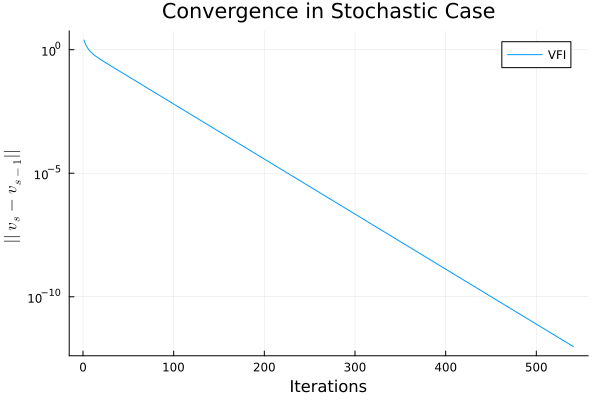

In [4]:
plot(1:length(errors), errors, 
    yscale = :log10,
    title  = "Convergence in Stochastic Case",
    xlabel = "Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    label  = "VFI",
    # yticks = 10.0.^(0:-2:-10)
)

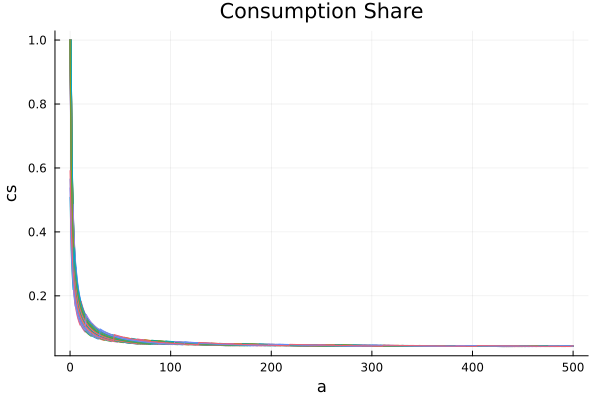

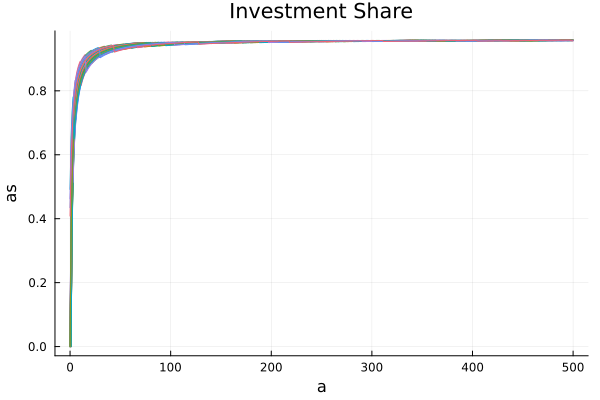

In [5]:
solution = solve_vfi2!(p, a_grid, V0)
@unpack r, β = p
@unpack a_grid, y_grid = solution
a′ = a_grid[solution.policy]
z  = (1 + r) .* a_grid .+ exp.(y_grid')
c  = z .- a′

# Consumption/investment share 
cs = c./z
as = a′./z

plot_consumption_share = plot(a_grid, cs, xlabel="a", ylabel="cs", title="Consumption Share", legend = false)
display(plot_consumption_share)
plot_investment_share = plot(a_grid, as, xlabel="a", ylabel="as", title="Investment Share", legend = false)
display(plot_investment_share)

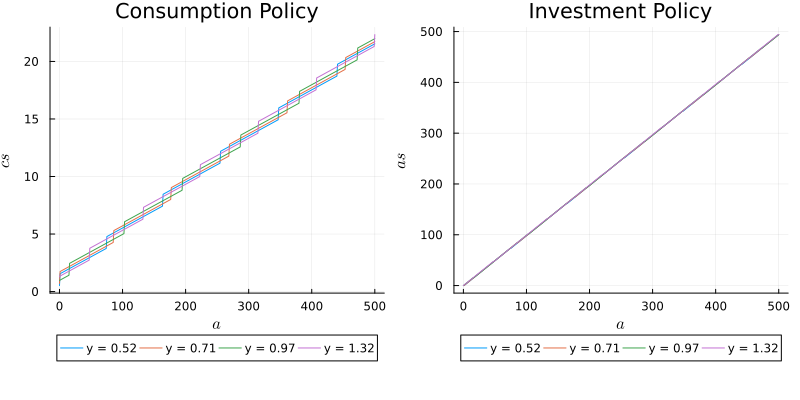

In [6]:
## Consumption policy for a variety of y values 
yVals = [5, 10, 15, 20]
p1 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, c[:, yi], label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Consumption Policy")
ylabel!(raw"$cs$")
xlabel!(raw"$a$")


## Next let's plot investment policy for the same y values
p2 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, a′[:, yi] , label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Investment Policy")
ylabel!(raw"$as$")
xlabel!(raw"$a$")



plt = plot(p1, p2, size = (800, 400), layout = (1, 2))

For a tolerance level of 1e-3, Res ≈ 0 for ∀ value of the asset grid higher than  : 30.06012024142084


Plots.AnimatedGif("C:\\Users\\reube\\AppData\\Local\\Temp\\jl_eVGp6XgFml.gif")
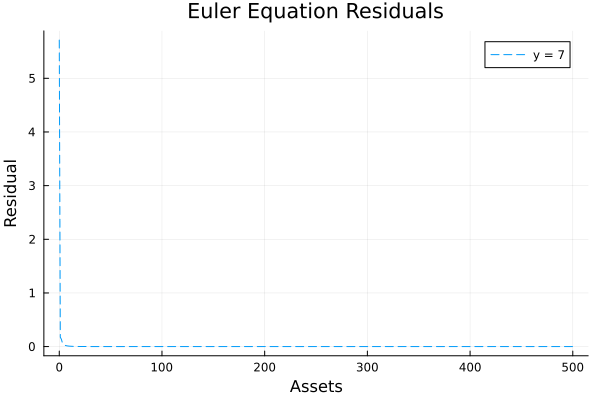

┌ Info: Saved animation to C:\Users\reube\AppData\Local\Temp\jl_eVGp6XgFml.gif
└ @ Plots C:\Users\reube\.julia\packages\Plots\HyyIK\src\animation.jl:156


In [7]:
u′(c) = c^(-p.σ)

tolerance = 1e-3
res = zeros(size(a_grid, 1), size(y_grid, 1))
for (i, a) in enumerate(a_grid)
    for (j, y) in enumerate(y_grid)
        c = z[i, j]
        EV = 0.0
        for (jp, yjp) in enumerate(y_grid)
            c′ = z[findfirst(x -> x >= a′[i, jp], a_grid), jp]
            EV += u′(c′) * solution.P[j, jp]
        end
        res[i, j] = u′(c) - β * (1 + r) * EV
        
        if abs(res[i, j]) < tolerance
            res[i, j] = 0
        end
    end
end

zero_asset_indices = findall(res .== 0)

if isempty(zero_asset_indices)
    println("No such value found on the asset grid.")
else
    first_zero_asset_index = first(zero_asset_indices)
    first_zero_asset_value = a_grid[first_zero_asset_index]
    println("For a tolerance level of 1e-3, Res ≈ 0 for ∀ value of the asset grid higher than  : $first_zero_asset_value")
end

# Plot the residuals for representative values of y
yvals = collect(1:4) .* div(p.Ny, 4)
@gif for (j, y) in enumerate(yvals)
    plot_anim = plot(a_grid, res[:, j], label="y = $y", linestyle=:dash)
    xlabel!("Assets")
    ylabel!("Residual")
    title!("Euler Equation Residuals")  
end fps = 0.5

The Euler equation residual fluctuates around zero without ever reaching it before the end of the asset grid. 


From here we use a different code for setting up the question.

In [8]:
abstract type ContinuousInterp          end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch
    Nl::Int
end 

interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))

interpolant (generic function with 4 methods)

In [14]:
"""
BewleyParams contains all of the parameters that we need to solve the
neoclassical growth model (Ramsey Model) with endogenous labour supply. 
This allows us to pass it around as a single object. 
"""
@with_kw struct BewleyParams{T}
    β::Float64  = 0.95  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = .03   
    μ::Float64  = 0.5   
    ρ::Float64  = 0.8
    σϵ::Float64 = 0.1 
    σ::Float64  = 2
    τy::Float64 = 0.0   # income tax  -- not used until part (d)
    τa::Float64 = 0.0   # capital tax -- not used until part (d)
    Na::Int     = 100
    Ny::Int     = 15
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
Base.broadcastable(p::BewleyParams) = Ref(p) # makes broadcasting work properly

u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))

function setup(p::BewleyParams, interp_mode::ContinuousInterp)
    @unpack Na, Ny, ρ, σϵ, μ = p 
    
    # Capital Grid 
    if interp_mode isa ChebyInterp
        agrid = chebpoints(Na-1, 0, 300)
    else
        agrid = LinRange(0, 500, Na)
    end
    
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Na, Ny)
    V0 = zeros(Na, Ny)
    EV = zeros(Na, Ny)

    policy = (
        c = zeros(Na, Ny),
        a = zeros(Na, Ny)
    )

    return (; V, V0, EV, policy, agrid, ygrid, P)
end

function solve!(p::BewleyParams, m; tol = 1e-8, maxiter = 1000)
    @unpack V, V0       = m
    @unpack interp_mode = p
    iter = 0 
    while true
        iter += 1 
        update_bellman!(p, m)

        err = maximum(abs.(V - V0))
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter)
end


function update_bellman!(p::BewleyParams, m)
    @unpack EV, P, V0, V, policy, agrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV) 
    
    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for za in eachindex(agrid)
            @unpack v′, c, a = solve_inner(p, m, EV̂, za, zy)
            V[za, zy]           = v′
            policy.c[za, zy]    = c
            policy.a[za, zy]    = a
        end
    end
    return
end

function solve_inner(p::BewleyParams, m, EV, za, zy)
    @unpack agrid, ygrid = m
    @unpack β, r, τy, τa = p
    a = agrid[za]
    y = exp(ygrid[zy])
    z = (1+r) * a + y - τa * r * a - τy * y

    obj(a′) = u(p, z - a′) + β * EV(a′, ygrid[zy])
    lb      = 0.0
    ub      = min(z - 1e-6, maximum(agrid))     # ensure c ≥ 1e-6, a′ ≤ a̅
    res     = optimize(a′ -> - obj(a′), lb, ub)
    v′      = - minimum(res)
    a′      = minimizer(res)
    c       = z - a′

    return (; v′, c, a = a′)
end

function F(p, k, l) 
    @unpack A, α = p
    return A * k^α * l^(1-α)
end

"""
RamseyParams contains all of the parameters that we need to solve the
neoclassical growth model (Ramsey Model) with endogenous labour supply. 
This allows us to pass it around as a single object. 
"""
@kwdef @concrete struct RamseyParams
    β = 0.95
    δ = 0.05
    σ = 2.0
    ν = 2
    α = 1/3
    A = 1
    ϕ = 1
    Nk = 100
    interp_mode = CubicSplines()
end
Base.broadcastable(p::RamseyParams) = Ref(p) # makes broadcasting work properly

p = RamseyParams(
    β = 0.95, 
    δ = 0.05,
    σ = 2, 
    ν = 2, 
    α = 1/3,
    A = 1,
    ϕ = 1,
    Nk = 200,
    interp_mode = GridSearch(100)
)

setup(p) = setup(p, p.interp_mode)

function setup(p::RamseyParams, method::GridSearch)
    @unpack Nk = p
    @unpack Nl = method

    kgrid = LinRange(1e-2, 10, Nk)
    
    return (
        V = zeros(Nk),
        policy = (
            l  = 0.5 * ones(Nk),
            k  = zeros(Nk),
            c  = zeros(Nk)
        ),
        V0 = zeros(Nk),
        kgrid, 
        lgrid = LinRange(0, 1, Nl)
    )
end

p = BewleyParams(Ny = 30)
m = setup(p)
solve!(p, m);

In [15]:
function simulate(p::BewleyParams, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)
    

    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

a, y, c = simulate(p, m, N = 10_000, T = 1000)


(a = [1.009618009800614, 9.099126170535092, 16.084054849733786, 0.18803276793222898, 0.14034001191925624, 0.03908859846944197, 2.7580562540092552, 0.17160802927933752, 2.9955977234927174, 1.2064494042993048  …  5.122112188400094, 20.228009592680824, 14.061074606550015, 7.729365502532343, 11.931977777531063, 10.746268133278328, 1.2401822498735853, 7.563511497334474, 3.138903228317155, 0.9563385973172063], y = [2.345253884852457, 2.530949223029509, 2.6547461151475438, 2.1595585466754055, 2.345253884852457, 2.4071523309114746, 2.28335543879344, 2.345253884852457, 2.4690507769704917, 2.716644561206561  …  2.8404414533245954, 2.6547461151475438, 2.6547461151475438, 2.716644561206561, 2.716644561206561, 2.5928476690885263, 2.4071523309114746, 2.4690507769704917, 2.28335543879344, 2.7785430072655783], c = [10.739058581380299, 13.518382608869839, 14.733758197135307, 8.746339383590648, 10.478058843879111, 11.111779702196536, 10.770057867510648, 10.487447030791762, 12.33272948595825, 13.72862367

Setting up the question from the solutions of problem set 7 changing the interest rate r.
Using the fact that $u'(c) = c^{-\theta}$ for $\theta =2$.

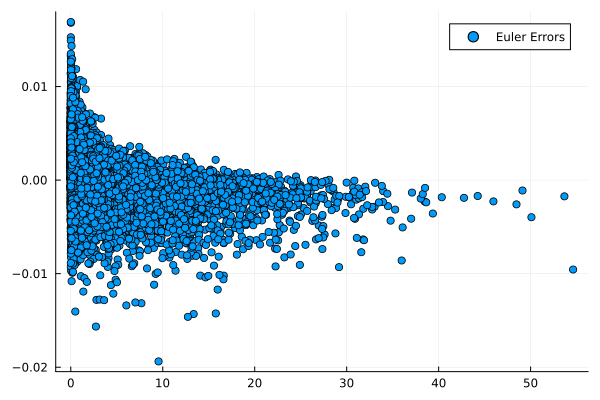

In [17]:
# Define a function to compute the LHS and RHS of the Euler equation
function euler_equation(c, p, m)
    @unpack β, r = p
    @unpack V = m
    lhs_values = Float64[]
    rhs_values = Float64[]
    for i in 1:length(c)-1
        lhs = 1 / c[i]^2
        rhs = β * (1 + r) * (1/c[i+1]^2)
        push!(lhs_values, lhs)
        push!(rhs_values, rhs)
    end
    return lhs_values, rhs_values
end
# Define the range of values for c
c_vals = c
lhs, rhs = euler_equation(c, p, m)

plot(a, lhs-rhs, seriestype = :scatter, label = "Euler Errors")

I thought it would be interesting to see if rather than finding next periods consumption through interpolation we actually looked at the outcomes from the next peiods and plotted the LHS-RHS in a scatter plot. We founf what we had found above that mainly the Euler equation is not holding when the assets are low, especially as we get closer to no assets. This means that the utility gained from consuming one additional unit of a good is not equal to the discounted expected utility of future consumption. 

Part b

In [18]:
# Create an array to store histograms
histograms = []

# Define r values
r_values = [0.01, 0.02, 0.03, 0.04, 0.05]

# Iterate over r values and create histograms
for r in r_values
    p = BewleyParams(r = r)
    m = setup(p)
    solve!(p, m)
    df = simulate(p, m, N = 10_000, T = 1000)
    println("The mean asset holdings for r = $r is $(mean(df.a))")
end

The mean asset holdings for r = 0.01 is 1.2854393382547191
The mean asset holdings for r = 0.02 is 2.2999530333996923
The mean asset holdings for r = 0.03 is 4.511381109139912
The mean asset holdings for r = 0.04 is 9.463795350556913
The mean asset holdings for r = 0.05 is 49.62517252660965


We see that as the interest rate increases the final distribution of assets also increases. When interest rates rise, individuals are incentivised to save more and consume less due to the higher returns available on savings and investments. A higher interest rate implies greater potential earnings on savings. As a result, individuals may choose to allocate a larger portion of their income towards saving and investment activities to take advantage of these elevated returns. This increased propensity to save can lead to higher asset holdings among individuals as they seek to capitalise on the improved opportunities for wealth accumulation. Furthermore, higher interest rates can also make borrowing more expensive, prompting individuals to rely less on debt-financing and instead prioritise saving and investment as means of building wealth.

Part c

In [21]:
# Initialize r to a reasonable starting value
r = 0.03

# Define a tolerance for the mean asset holding
tolerance = 1e-3

# Maximum number of iterations to prevent infinite loop
max_iterations = 1000

# Counter for iterations
iteration_count = 0

while true
    # Break the loop if maximum iterations reached
    if iteration_count >= max_iterations
        println("Maximum iterations reached. Exiting loop.")
        break
    end
    
    p = BewleyParams(r = r)
    m = setup(p)
    solve!(p, m)
    df = simulate(p, m, N = 10_000, T = 1000)
    
    mean_asset_holding = mean(df.a)
    
    # Check if the mean asset holding is within the tolerance
    if abs(mean_asset_holding - 5.1) < tolerance
        println("The mean asset holdings for r = $r is $mean_asset_holding")
        break
    end
    
    # Adjust r based on the comparison with the target mean asset holding
    if mean_asset_holding > 5.1
        r -= 0.0001
    else
        r += 0.0001
    end
    
    # Increment iteration count
    iteration_count += 1
end

The mean asset holdings for r = 0.03180000000000001 is 5.100153609525165


I believe that I got very lucky by initially selecting r=0.03 as the starting interest rate otherwise this method of iteration might take a very long time. And a bisection method would probably be a faster method, to find the optimal interest rate.

Part d

To optimise the parameters of the model to align with the asset holdings of the economy given an infinite computational budget, we can employ an advanced methodological approach known as the Simulated Method of Moments (SMM).

Firstly, we organise our parameters into a vector $\mathbf{y}$ and our regressors into a matrix $\mathbf{X}$. By employing Ordinary Least Squares (OLS), we aim to determine the parameter vector $\beta$ such that the covariance between the predicted residuals and the regressors is minimised. This can be expressed through a set of $k$ distinct "moments", encapsulated in the OLS "moment function" $m: \mathbb{R}^k \rightarrow \mathbb{R}^k$, defined as $m(\beta) = \mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta)$.

To specify a value for $r$, crucial for modelling aspects such as interest rates and patience, we avoid arbitrary selection and instead opt for estimation grounded in data congruence. As $r$ influences not only interest rates but also factors like patience, affecting variables such as $C_t$, $Y_t$, and $A_t$, we address this through a root-finding approach. By determining when the average assets reach a designated threshold, such as 5.1, we iteratively solve for $r$.

However, this iterative process can be computationally intensive, especially with an extensive parameter space. To streamline this, we generalise the approach to incorporate multiple moments from our model. This extension of SMM allows us to efficiently estimate a vector of parameters $\hat{\theta}$ by leveraging $n$ informative moments $\bar{m}$ derived from the data. Here, $m: \mathbb{R}^k \rightarrow \mathbb{R}^k$ encapsulates the model's simulation process and the subsequent computation of model-specific moments.

While aiming to converge on a solution where the average assets match the desired value, this process may demand significant computational resources. However, with an infinite computational budget, SMM presents a robust framework for parameter estimation tailored to the complexities of economic asset holdings.
